# K - clustering for edge devices
## Tables of contents
### 1.Feature Definition and Data Collection
- Select measurable features suitable for edge devices .
- Collect data from devices or public datasets.
- Normalize and store data efficiently for limited hardware.
### 2. K-Means Classification on Edge Devices
- Implement a lightweight K-Means algorithm optimized for CPU/GPU constraints.
- Data Standardization.
- Finding Optimal Number of Clusters
  + Elbow Method.
  + Silhouette Score.
- PCA for Visualization.
- Saving and Exporting Results.
- Demonstration: Mango classification using the [dataset](https://www.kaggle.com/code/muhammadmuzammil196/k-mean-mangoes-clustering).
### 3. Integration with Split Inference
- Extract features on the edge device to minimize bandwidth.
- Perform clustering locally for real-time classification.
- Offload model retraining to the cloud.
- Synchronize updated cluster centers back to devices with minimal data transfer.


### 1. Define feature and collect data

### 2. Build algorithm

In [241]:
# ==========================================================
# 1. IMPORT LIBRARIES
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [242]:
# ==========================================================
# 2. LOAD DATA
# ==========================================================
df = pd.read_csv("Devices2.csv")
display(Markdown("### 🟩 Dữ liệu đầu vào"))
display(df.head())
print(df.shape)


### 🟩 Dữ liệu đầu vào

,CPU,ATRam,ATStorage,Internet
0,0.009,0.866667,0.743450,1000
1,0.025,0.729730,0.672414,100
2,0.008,0.753425,0.724138,1000
3,0.008,0.323077,0.542373,100
4,0.045,0.589744,0.110000,1000


(18, 4)


In [243]:

# ==========================================================
# 3. TIỀN XỬ LÝ (XỬ LÝ NA, LỌC CỘT SỐ)
# ==========================================================
df = df.dropna()

# Lấy các cột dạng numeric để phân cụm
num_df = df.select_dtypes(include=[np.number])

display(Markdown("### 🟦 Dữ liệu số dùng để phân cụm"))
display(num_df.head())


### 🟦 Dữ liệu số dùng để phân cụm

,CPU,ATRam,ATStorage,Internet
0,0.009,0.866667,0.743450,1000
1,0.025,0.729730,0.672414,100
2,0.008,0.753425,0.724138,1000
3,0.008,0.323077,0.542373,100
4,0.045,0.589744,0.110000,1000


In [244]:
# ==========================================================
# 4. CHUẨN HÓA VÀ GÁN TRỌNG SỐ
# ==========================================================

# Trọng số yêu cầu
weights = {
    "CPU": 2,
    "ATRam": 2,
    "ATStorage": 1,
    "Internet": 1
}

display(Markdown("4.1. Chuẩn hóa dữ liệu (Standardization)"))

# 1. Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

# Tạo DataFrame tạm thời từ X_scaled để dễ dàng áp dụng trọng số
df_scaled = pd.DataFrame(X_scaled, columns=num_df.columns)

display(Markdown("4.2. Gán Trọng số cho Dữ liệu đã chuẩn hóa"))

# 2. Áp dụng Trọng số lên từng cột trong df_scaled
for feature, weight in weights.items():
    # Kiểm tra xem cột có tồn tại không trước khi nhân
    if feature in df_scaled.columns:
        df_scaled[feature] = df_scaled[feature] * weight
        display(Markdown(f"Đã nhân trọng số **{weight}** cho cột **{feature}**"))
    else:
        display(Markdown(f"Cảnh báo: Cột **{feature}** không tồn tại trong dữ liệu đã chuẩn hóa."))

# Lấy mảng NumPy cuối cùng đã được chuẩn hóa và gán trọng số
X_weighted = df_scaled.values

display(Markdown("Dữ liệu sau khi Chuẩn hóa và Gán Trọng số (5 hàng đầu):"))
display(df_scaled.head())

4.1. Chuẩn hóa dữ liệu (Standardization)

4.2. Gán Trọng số cho Dữ liệu đã chuẩn hóa

Đã nhân trọng số **2** cho cột **CPU**

Đã nhân trọng số **2** cho cột **ATRam**

Đã nhân trọng số **1** cho cột **ATStorage**

Đã nhân trọng số **1** cho cột **Internet**

Dữ liệu sau khi Chuẩn hóa và Gán Trọng số (5 hàng đầu):

,CPU,ATRam,ATStorage,Internet
0,-1.090024,1.210691,2.009724,-0.933543
1,-0.195645,-0.806048,1.697888,-1.126690
2,-1.145923,-0.457081,1.924949,-0.933543
3,-1.145923,-6.795028,1.127030,-1.126690
4,0.922328,-2.867694,-0.771016,-0.933543


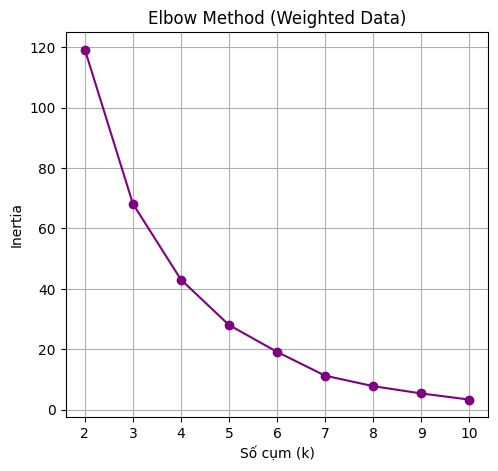

In [245]:
# ==========================================================
# 5. TÌM SỐ CLUSTER TỐI ƯU (DỮ LIỆU ĐÃ CÓ TRỌNG SỐ)
# ==========================================================
inertias = []
sil_scores = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_weighted) # SỬ DỤNG DỮ LIỆU ĐÃ GÁN TRỌNG SỐ (X_weighted)

    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_weighted, km.labels_))

# Trực quan hóa Elbow Method
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(K, inertias, marker='o', color='purple')
plt.title("Elbow Method (Weighted Data)")
plt.xlabel("Số cụm (k)")
plt.ylabel("Inertia")
plt.grid(True)



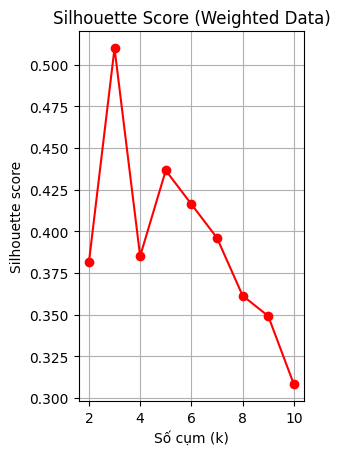

In [246]:
# 6 Trực quan hóa Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K, sil_scores, marker='o', color='red')
plt.title("Silhouette Score (Weighted Data)")
plt.xlabel("Số cụm (k)")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()


In [247]:
# 7 Chọn K tối ưu dựa trên Silhouette Score cao nhất
best_k_weighted = K[np.argmax(sil_scores)]
display(Markdown(f"### K Tối ưu mới (Weighted): **K = {best_k_weighted}**"))

### K Tối ưu mới (Weighted): **K = 3**

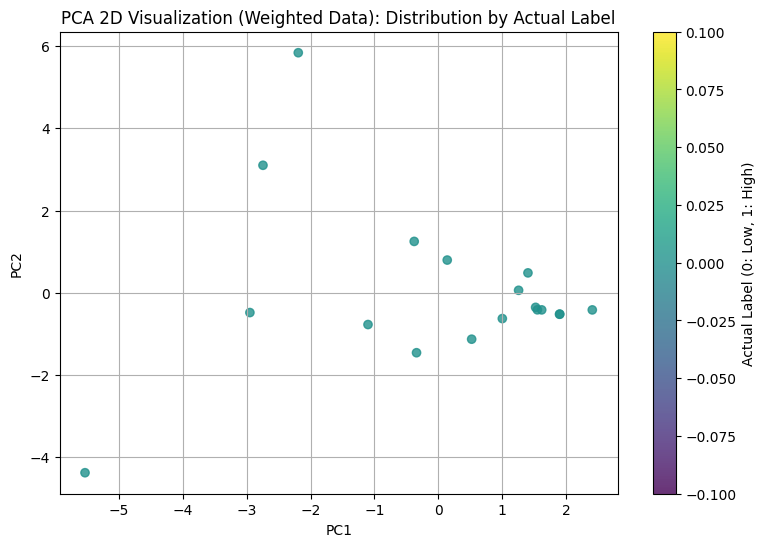

In [248]:
# ==========================================================
# 8. CHUẨN BỊ, PCA VÀ CHIA TẬP DỮ LIỆU
# ==========================================================

# 1. Tái tạo Chuẩn hóa và Gán trọng số (Đảm bảo X_weighted được định nghĩa)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

# Gán trọng số
df_scaled = pd.DataFrame(X_scaled, columns=num_df.columns)
for feature, weight in weights.items():
    if feature in df_scaled.columns:
        df_scaled[feature] = df_scaled[feature] * weight

X_weighted = df_scaled.values
# -------------------------------------------------------------


# 2. TẠO LABEL GỐC (Ground Truth)
df_temp = df.copy()
df_temp["Label"] = (
        (df_temp["CPU"] + df_temp["ATRam"]) >
        (df_temp["ATStorage"] + df_temp["Internet"])
).astype(int)

# 3. Lấy features PCA đã tính từ dữ liệu CÓ TRỌNG SỐ (X_weighted)
pca_weighted = PCA(n_components=2)
X_pca_weighted = pca_weighted.fit_transform(X_weighted)

# 4. Gán Features PCA vào DataFrame
df_temp["PC1_Weighted"] = X_pca_weighted[:, 0]
df_temp["PC2_Weighted"] = X_pca_weighted[:, 1]

# 5. CHIA TẬP DỮ LIỆU
X = X_pca_weighted  # Features cho mô hình (2D PCA từ dữ liệu có trọng số)
Y = df_temp["Label"].values  # Nhãn gốc (Label 0 hoặc 1)

x_train, x_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.3,
    random_state=42
)

pca_weighted = PCA(n_components=2).fit(X_weighted)

plt.figure(figsize=(9, 6))
# Sử dụng PC1 và PC2 từ dữ liệu đã gán trọng số (X_pca_weighted)
# Tô màu dựa trên nhãn gốc (Label 0 / 1)
scatter = plt.scatter(X_pca_weighted[:, 0], X_pca_weighted[:, 1],
                    c=df_temp["Label"], cmap='viridis', alpha=0.8)

plt.title("PCA 2D Visualization (Weighted Data): Distribution by Actual Label")
plt.xlabel(f"PC1")
plt.ylabel(f"PC2")
plt.colorbar(scatter, label="Actual Label (0: Low, 1: High)")
plt.grid(True)
plt.show()

In [249]:
# ==========================================================
# 9. HÀM K-MEANS THỦ CÔNG
# ==========================================================

def manual_kmeans(X, k=2, max_iter=100):

    # Khởi tạo tâm cụm ngẫu nhiên
    init_centers = X[np.random.choice(len(X), k, replace=False)].copy()
    centers = init_centers.copy()

    for _ in range(max_iter):
        # --- ASSIGN STEP ---
        clusters = [[] for _ in range(k)]
        for point in X:
            idx = np.argmin(np.linalg.norm(point - centers, axis=1))
            clusters[idx].append(point)

        # --- UPDATE STEP ---
        new_centers = np.array([np.mean(c, axis=0) if len(c) > 0 else centers[i]
                                for i, c in enumerate(clusters)])

        # Kiểm tra điều kiện dừng
        if np.allclose(new_centers, centers):
            break
        centers = new_centers.copy()

    return centers, clusters, init_centers


def nearest_point(points, center):
    """Tìm điểm huấn luyện gần nhất với tâm cụm."""
    return min(points, key=lambda p: np.linalg.norm(p - center))


def get_center_id(point, centers):
    """Tìm ID của tâm cụm gần nhất."""
    return np.argmin(np.linalg.norm(centers - point, axis=1))


### Chạy K-Means Thủ công với K = 2

#### Ánh xạ Cụm (K=2) sang Nhãn Gốc:

Cluster 0 -> Label 0
Cluster 1 -> Label 0


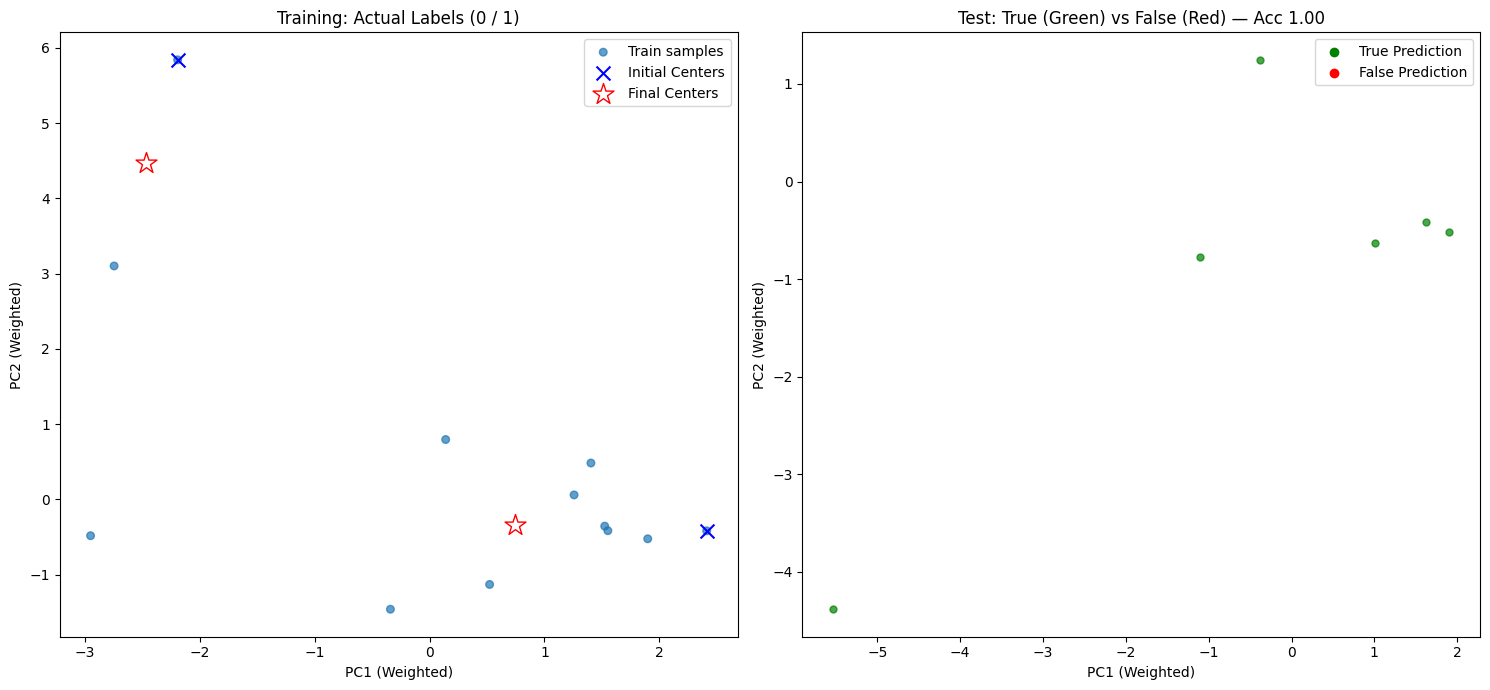

### Kết quả Đánh giá K-Means Thủ công (K=3)

True Predictions: 6, False Predictions: 0
Accuracy: 1.00


In [250]:
# ==========================================================
# 10. HÀM TEST_KMEANS VÀ TRỰC QUAN HÓA (K=2 cho Phân loại)
# ==========================================================
from sklearn.metrics import accuracy_score

def test_kmeans(x_train, y_train, x_test, y_test):

    num_clusters = 2
    max_iterations = 100

    display(Markdown(f"### Chạy K-Means Thủ công với K = {num_clusters}"))

    # 1. Huấn luyện trên tập TRAIN
    centers, _, init_centers = manual_kmeans(x_train, k=num_clusters, max_iter=max_iterations)

    # 2. ÁNH XẠ TÂM CỤM → NHÃN GỐC
    pred_center_labels = []

    for c in centers:
        nearest = nearest_point(x_train, c)
        idx = np.where(np.all(x_train == nearest, axis=1))[0][0]
        mapped_label = y_train[idx]
        pred_center_labels.append(mapped_label)

    display(Markdown("#### Ánh xạ Cụm (K=2) sang Nhãn Gốc:"))
    for cluster, label in enumerate(pred_center_labels):
        print(f"Cluster {cluster} -> Label {label}")


    # 3. PLOT (Vẽ sơ đồ Train/Test)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

    # --- TRAINING FIGURE (LEFT) ---
    train_colors = ['#1f77b4' if m == 0 else '#ff7f0e' for m in y_train]

    ax0.scatter(x_train[:, 0], x_train[:, 1], color=train_colors, alpha=0.7, s=30, label="Train samples")
    ax0.scatter(init_centers[:, 0], init_centers[:, 1], color='blue', marker='x', s=100, label="Initial Centers")
    ax0.scatter(centers[:, 0], centers[:, 1], color='white', edgecolor='red', marker='*', s=250, label="Final Centers")

    ax0.set_title("Training: Actual Labels (0 / 1)")
    ax0.set_xlabel("PC1 (Weighted)")
    ax0.set_ylabel("PC2 (Weighted)")
    ax0.legend()

    # --- TEST FIGURE (RIGHT) & TÍNH ACCURACY ---
    true_predict = 0
    false_predict = 0
    y_pred = []

    for i in range(len(x_test)):
        p = x_test[i]
        cid = get_center_id(p, centers)
        pred_label = pred_center_labels[cid]
        y_pred.append(pred_label)

        if pred_label == y_test[i]:
            color = 'Green'
            true_predict += 1
        else:
            color = 'Red'
            false_predict += 1

        ax1.plot(x_test[i, 0], x_test[i, 1], 'o', color=color, alpha=0.7, markersize=5)

    accuracy = accuracy_score(y_test, y_pred)


    ax1.set_title(f"Test: True (Green) vs False (Red) — Acc {accuracy:.2f}")
    ax1.set_xlabel("PC1 (Weighted)")
    ax1.set_ylabel("PC2 (Weighted)")

    # Tạo chú thích cho biểu đồ Test
    ax1.scatter([], [], color='Green', label="True Prediction")
    ax1.scatter([], [], color='Red', label="False Prediction")
    ax1.legend()

    plt.tight_layout()
    plt.show()

    display(Markdown("### Kết quả Đánh giá K-Means Thủ công (K=3)"))
    print(f"True Predictions: {true_predict}, False Predictions: {false_predict}")
    print(f"Accuracy: {accuracy:.2f}")


# ============================================
# THỰC THI (Run)
# ============================================
test_kmeans(x_train, y_train, x_test, y_test)